In [1]:
import json
from collections import defaultdict
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re

/home/cmu/miniconda3/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = AutoTokenizer.from_pretrained("d1shs0ap/cognitive-behaviors-Llama-3.2-3B")

In [ ]:
step_to_rollouts = {}

for step in range(0, 72 + 1, 24):
    rollouts_file = f"/home/cmu/countdown-curriculum/checkpoints/train-5-5-normal-2048/{step}_rollouts.json"
    with open(rollouts_file, 'r') as f:
        step_to_rollouts[step] = json.load(f)


In [18]:
k = []
p = []

for step in range(0, 72 + 1, 24):
    
    rollouts = step_to_rollouts[step]
    attempts = 0
    successes = 0
    total = 0
    for rollout in rollouts:
        if rollout['ref_score'] != 5:
            continue

        attempts += len(set(rollout['output'].split('\n\n')))
        successes += rollout['score']
        total += 1
    
    k.append(attempts / total)
    p.append(successes / attempts)

In [13]:
step_to_positive_rollouts = {}

for step in range(0, 72 + 1, 24):
    rollouts_file = f"/home/cmu/countdown-curriculum/checkpoints/train-5-5-positive-2048/{step}_rollouts.json"
    with open(rollouts_file, 'r') as f:
        step_to_positive_rollouts[step] = json.load(f)

In [19]:
new_k = []
new_p = []

for step in range(0, 72 + 1, 24):
    
    rollouts = step_to_positive_rollouts[step]
    attempts = 0
    successes = 0
    total = 0
    for rollout in rollouts:
        if rollout['ref_score'] != 5:
            continue

        attempts += len(set(rollout['output'].split('\n\n')))
        successes += rollout['score']
        total += 1
    
    new_k.append(attempts / total)
    new_p.append(successes / attempts)

Text(0.5, 0, 'Steps')

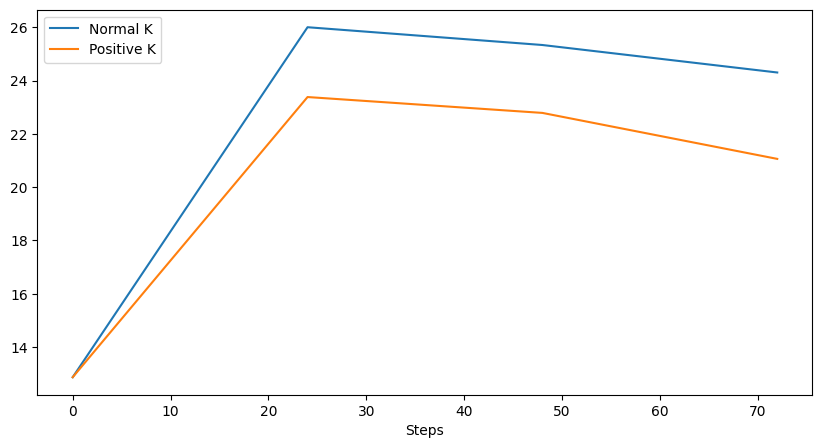

In [20]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=step_to_rollouts.keys(), y=k, label='Normal K')
sns.lineplot(x=step_to_rollouts.keys(), y=new_k, label='Positive K')
plt.xlabel('Steps')


Text(0.5, 0, 'Steps')

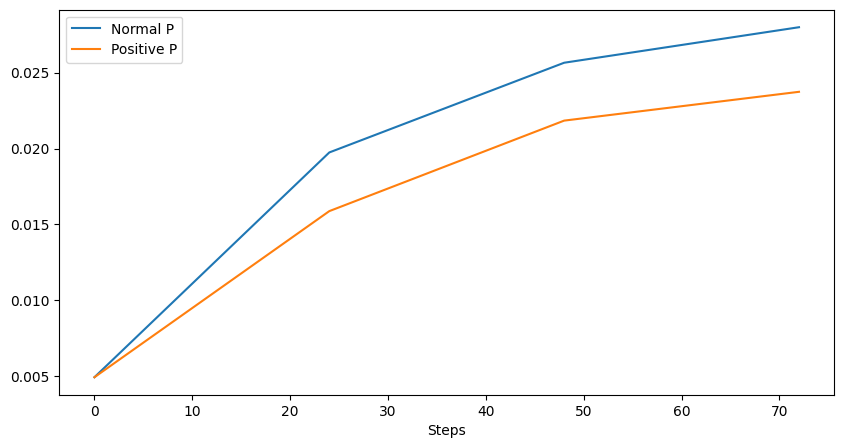

In [21]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=step_to_rollouts.keys(), y=p, label='Normal P')
sns.lineplot(x=step_to_rollouts.keys(), y=new_p, label='Positive P')
plt.xlabel('Steps')

In [34]:
def extract_equations(attempt):
    equation_line_pattern = re.compile(r'^([\d\s\+\-\*/=]+)')

    equations = []
    for line in attempt.strip().split('\n'):
        line = line.strip()
        match = equation_line_pattern.match(line)
        if match:
            cleaned_eq = match.group(1).strip()
            equations.append(cleaned_eq)
        elif any(op in line for op in '+-*/='):  # fallback: manually extract left side before any annotation
            cleaned_eq = re.split(r'\s*\(.*?\)', line)[0].strip()
            equations.append(cleaned_eq)

    return equations

In [ ]:
k = []
p = []
problem_to_cum_attempts = defaultdict(set)

for step in range(0, 72 + 1, 24):
    
    rollouts = step_to_rollouts[step]
    attempts = 0
    successes = 0
    total = 0
    for i in range(len(rollouts) // 8):
        if rollouts[i * 8]['ref_score'] != 5:
            continue

        for j in range(8):
            rollout = rollouts[i * 8 + j]

            for attempt in set(rollout['output'].split('\n\n')):
                problem_to_cum_attempts[i].add('\n'.join(extract_equations(attempt)))

            successes += rollout['score']
            total += 1
        
        attempts += len(problem_to_cum_attempts[i])

    k.append(attempts / total)
    p.append(successes / attempts)

In [44]:
new_k = []
new_p = []
problem_to_cum_attempts = defaultdict(set)

for step in range(0, 72 + 1, 24):
    
    rollouts = step_to_positive_rollouts[step]
    attempts = 0
    successes = 0
    total = 0
    for i in range(len(rollouts) // 8):
        if rollouts[i * 8]['ref_score'] != 5:
            continue

        for j in range(8):
            rollout = rollouts[i * 8 + j]

            for attempt in set(rollout['output'].split('\n\n')):
                problem_to_cum_attempts[i].add('\n'.join(extract_equations(attempt)))

            successes += rollout['score']
            total += 1
        
        attempts += len(problem_to_cum_attempts[i])

    new_k.append(attempts / total)
    new_p.append(successes / attempts)

Text(0.5, 0, 'Steps')

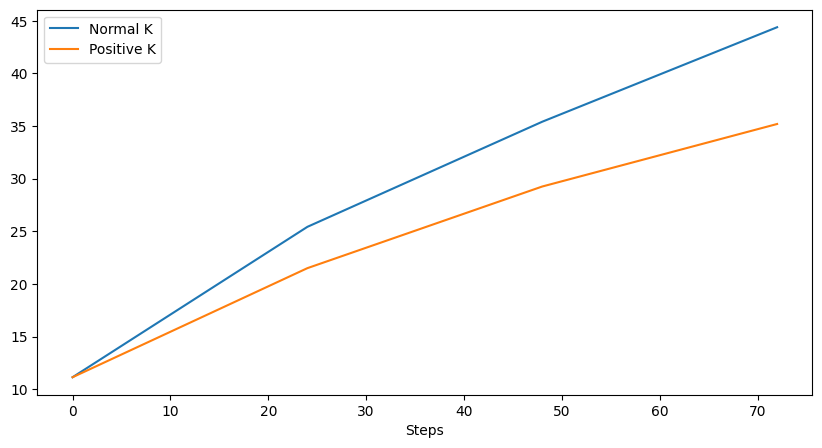

In [45]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=step_to_rollouts.keys(), y=k, label='Normal K')
sns.lineplot(x=step_to_rollouts.keys(), y=new_k, label='Positive K')
plt.xlabel('Steps')

Text(0.5, 0, 'Steps')

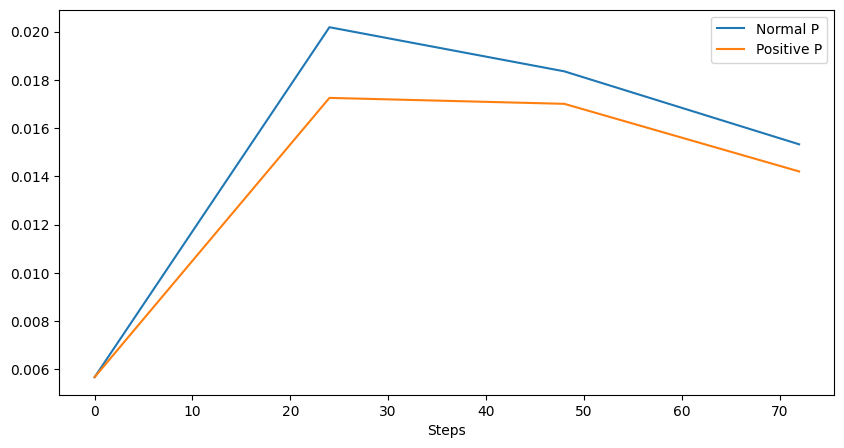

In [46]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=step_to_rollouts.keys(), y=p, label='Normal P')
sns.lineplot(x=step_to_rollouts.keys(), y=new_p, label='Positive P')
plt.xlabel('Steps')